# Feature Extraction: Edges

## Setup

In [1]:
!pip install webdataset

In [2]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv

from skimage import feature
from skimage import data, exposure
from skimage import filters

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import seaborn as sns



In [7]:
# paths
root = '/content/drive/My Drive/2024-12-09 281_Final-main'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/feature_data/edges'

# Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# # #alternate paths
# root = '.'
# data_folder = f'{root}/data'
# feature_data_folder = f'{root}/feature_data/edges/'

## Load Data

In [9]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns:
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [10]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

In [11]:
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (8430,)
Validation labels shape: (2821,)
Test labels shape: (403,)


In [12]:
print("Train imgs shape:", train_images.shape)
print("Validation imgs shape:", val_images.shape)
print("Test imgs shape:", test_images.shape)

Train imgs shape: (8430, 227, 227, 3)
Validation imgs shape: (2821, 227, 227, 3)
Test imgs shape: (403, 227, 227, 3)


7


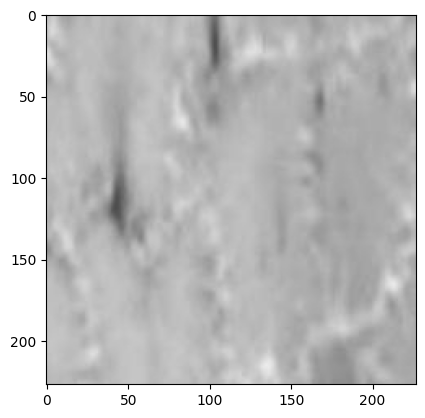

In [13]:
print(train_labels[0])
plt.imshow(train_images[0])

In [14]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8430, 227, 227, 3)
Shape of labels: (8430,)


## Quick EDA

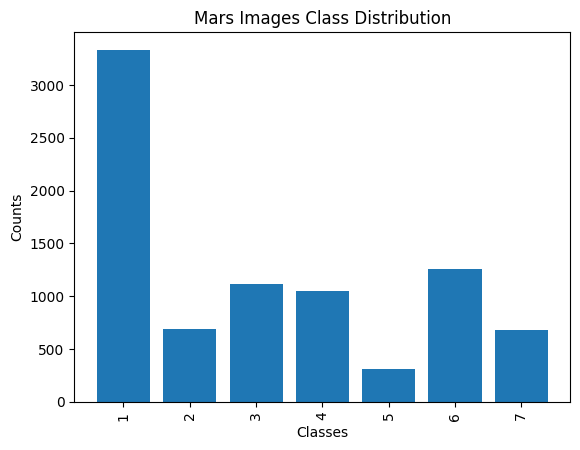

In [15]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dict = dict(zip(unique, counts))
#plot
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()), rotation = 'vertical')
plt.title('Mars Images Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

# View Class Samples

In [16]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Canny Edge Dectection Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])

    return sample_images, sample_labels

In [17]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

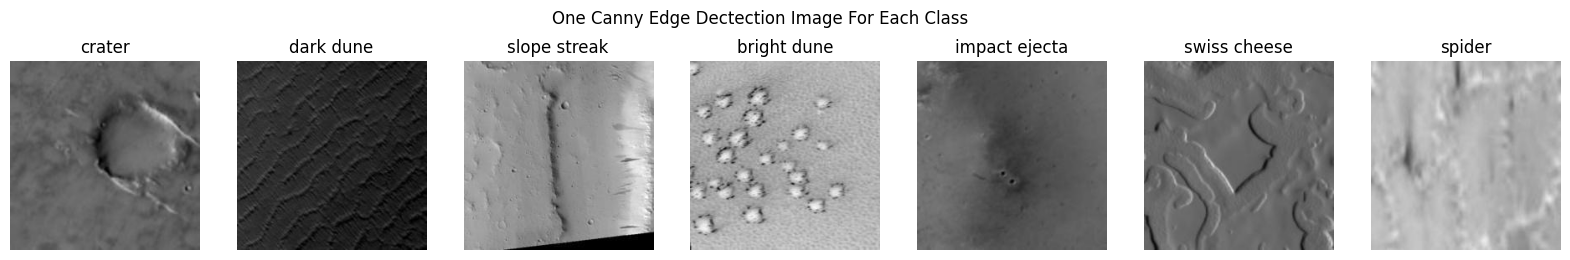

In [18]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: Edge Detection


In [19]:
def extract_raw_canny_edges(img_dataset, threshold1=100, threshold2=200):
    """
    Extract raw Canny edge maps from a dataset of grayscale images.

    args:
    - img_dataset: A list or array of grayscale images (numpy array).
    - threshold1: The first threshold for the Canny edge detection (default 100).
    - threshold2: The second threshold for the Canny edge detection (default 200).

    returns:
    - canny_edge_maps: A numpy array of the raw Canny edge maps for each image.
    """
    canny_edge_maps = []

    for img in img_dataset:
        # Apply Canny edge detection on the image
        edges = cv.Canny(img[:,:,0], threshold1=threshold1, threshold2=threshold2)
        canny_edge_maps.append(edges)

    # Convert the list of edge maps into a numpy array
    canny_edge_maps = np.array(canny_edge_maps)

    return canny_edge_maps

In [20]:
def extract_edge_lengths(img_dataset, threshold1=50, threshold2=100):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1 = threshold1, threshold2=threshold2)
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contour_lengths = [cv.arcLength(contour, closed=False) for contour in contours]
        #agg features
        total_length = sum(contour_lengths)
        mean_length = np.mean(contour_lengths) if contour_lengths else 0
        std_length = np.std(contour_lengths) if contour_lengths else 0
        num_contours = len(contours)
        features = np.array([total_length, mean_length, std_length, num_contours])
        total_features.append(features.flatten())
    return np.array(total_features)

In [21]:
def extract_edge_density(img_dataset, threshold1=100, threshold2=200):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1 = threshold1, threshold2=threshold2)
        num_edge_pixels = np.sum(edges > 0)
        total_pixels = edges.size
        edge_density = num_edge_pixels / total_pixels
        total_features.append(edge_density)
    return np.array(total_features)

In [22]:
def extract_edge_coords(img_dataset, threshold1=100, threshold2=200):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1=threshold1, threshold2=threshold2)
        y_coords, x_coords = np.where(edges > 0)
        coordinates = np.column_stack((x_coords, y_coords))

        desired_length = 1000
        if len(coordinates) > desired_length:
            # Randomly sample to reduce
            indices = np.random.choice(len(coordinates), desired_length, replace=False)
            sampled_coordinates = coordinates[indices]
        elif len(coordinates) < desired_length:
            # Pad with zeros to increase
            padding = np.zeros((desired_length - len(coordinates), 2), dtype=coordinates.dtype)
            sampled_coordinates = np.vstack((coordinates, padding))
        else:
            # Exact match
            sampled_coordinates = coordinates
        total_features.append(sampled_coordinates.flatten())
    return total_features

In [23]:
def extract_combined_features_edges(img_dataset, threshold1=100, threshold2=200):
    """
    Extract and combine various edge-related features for all images in the dataset.
    args:
    - img_dataset: The dataset of images (grayscale).
    returns:
    - all_features (numpy array): A matrix of combined features for each image in the dataset.
    """
    # Extract features using the predefined functions
    edge_lengths = extract_edge_lengths(img_dataset, threshold1=threshold1, threshold2=threshold2)
    edge_density = extract_edge_density(img_dataset, threshold1=threshold1, threshold2=threshold2)
    edge_coords = extract_edge_coords(img_dataset, threshold1=threshold1, threshold2=threshold2)

    # Combine all features for each image
    all_features = np.concatenate([
        edge_lengths,             # Contour length statistics
        edge_density[:, None],   # Edge density (reshaped to be a column vector)
        edge_coords               # Edge coordinates (flattened)
    ], axis=1)

    # Return the combined features matrix
    return np.array(all_features)


In [24]:
t_1 = 50
t_2 = 100

In [25]:
canny_features_train = extract_edge_lengths(train_images, threshold1=t_1, threshold2=t_2)

In [26]:
canny_features_val = extract_edge_lengths(val_images, threshold1=t_1, threshold2=t_2)

In [27]:
canny_features_test = extract_edge_lengths(test_images, threshold1=t_1, threshold2=t_2)

In [28]:
np.save(f'{feature_data_folder}/train_images_canny_edges.npy', canny_features_train)
np.save(f'{feature_data_folder}/val_images_canny_edges.npy', canny_features_val)
np.save(f'{feature_data_folder}/test_images_canny_edges.npy', canny_features_test)


# Create Visualization of Canny Edges for Each Class

In [29]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

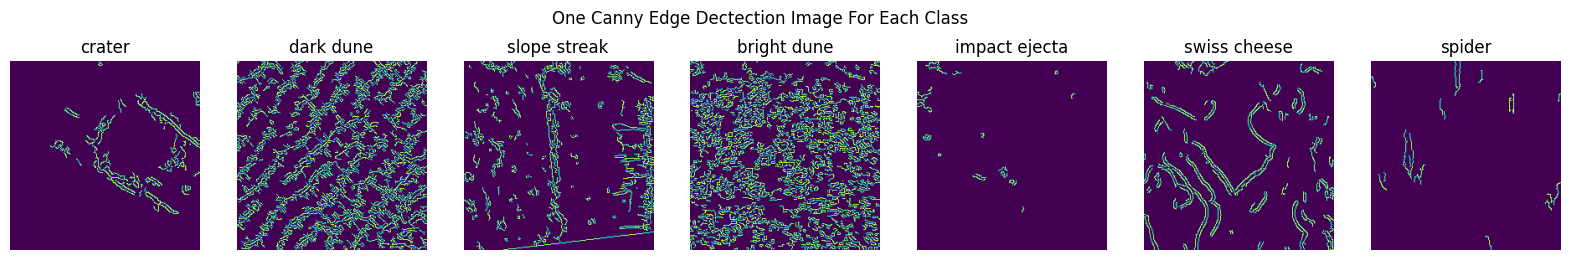

In [30]:
sample_imgs_canny = extract_raw_canny_edges(sample_imgs, threshold1=50, threshold2=100)
plot_class_samples(sample_imgs_canny, sample_lbls)

# Load features from saved edges npy

In [31]:
canny_features_train = np.load(f'{feature_data_folder}/train_images_canny_edges.npy')
canny_features_val = np.load(f'{feature_data_folder}/val_images_canny_edges.npy')
canny_features_test = np.load(f'{feature_data_folder}/test_images_canny_edges.npy')

# Data:
# edge_lengths contains the contour length statistics for each image.
# edge_density is a single value for each image, representing the edge density.
# edge_coords contains the flattened edge pixel coordinates for each image.


# Exploration and Visualization

In [32]:
# Set X and Y
X_train = canny_features_train
y_train = train_labels
X_val = canny_features_val
y_val = val_labels
X_test = canny_features_test
y_test = test_labels

In [33]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train data
X_val_scaled = scaler.transform(X_val)  # Apply the same scaling to validation data
X_test_scaled = scaler.transform(X_test)  # Apply the same scaling to test data



In [34]:
# Apply PCA for Dimensionality Reduction
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled) # Fit on train data
X_val_pca = pca.transform(X_val_scaled)  # Apply the same transformation to validation data
X_test_pca = pca.transform(X_test_scaled)  # Apply the same transformation to test data

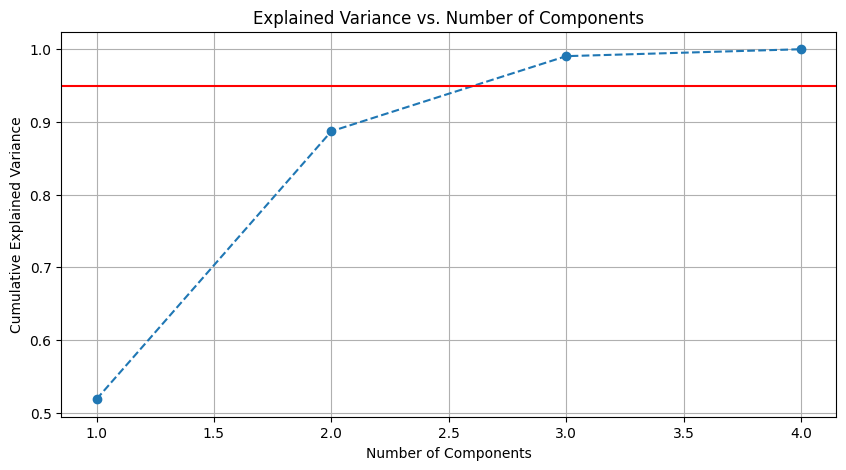

In [35]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 95% of explained variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
# Apply PCA for Dimensionality Reduction

# Update: Settled on using edge lengths, with dimension = 4
pca_1000 = PCA(n_components=1500)
X_train_pca = pca_1000.fit_transform(X_train_scaled) # Fit on train data
X_val_pca = pca_1000.transform(X_val_scaled)  # Apply the same transformation to validation data
X_test_pca = pca_1000.transform(X_test_scaled)  # Apply the same transformation to test data

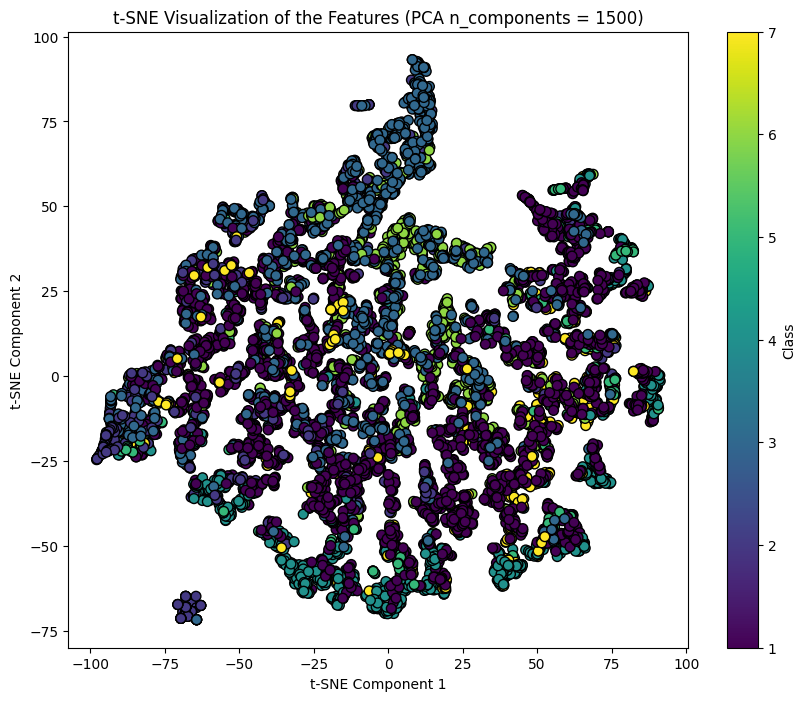

In [36]:
# Apply t-SNE for 2D Visualization (on PCA'ed)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)
# Visualize the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_labels, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='Class')
plt.title('t-SNE Visualization of the Features (PCA n_components = 1500)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Predictive Power

In [37]:
clf = LogisticRegression(max_iter = 2000).fit(X_train_scaled, train_labels) # Train on PCA-reduced features

In [38]:
clf.score(X_train_scaled, train_labels)

0.5040332147093713

In [39]:
clf.score(X_val_scaled, val_labels)


0.48280751506557956

In [40]:
preds = clf.predict(X_train_pca)
corr = preds == train_labels
df = pd.DataFrame({'correct': corr, 'label': train_labels})


In [41]:
df.head()


,correct,label
0,False,7
1,False,7
2,False,7
3,False,7
4,False,7


Text(0, 0.5, 'Count')

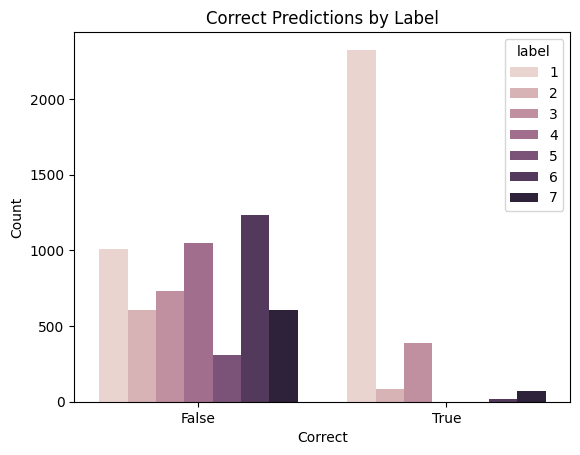

In [42]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

In [43]:
preds = clf.predict(X_val_pca)
corr = preds == val_labels
df = pd.DataFrame({'correct': corr, 'label': val_labels})


In [44]:
df.head()


,correct,label
0,False,4
1,False,4
2,False,4
3,False,4
4,False,4


Text(0, 0.5, 'Count')

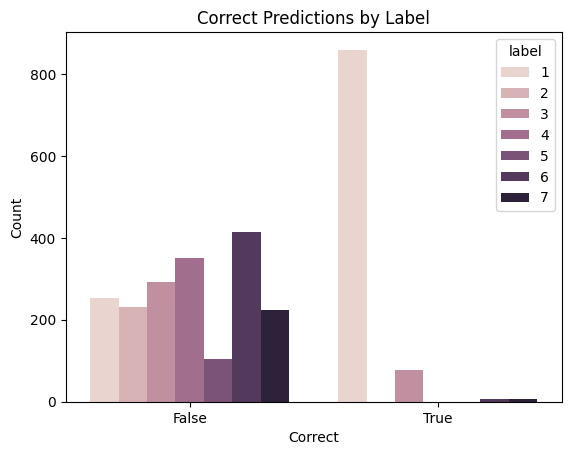

In [45]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')